In [1]:
import pandas as pd
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np

## Beolvasás és átalakítás

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['nan','?'], header=0,
                 dtype={'Date': str, 'Time': str, 'Global_active_power': float, 'Global_reactive_power': float,
                        'Voltage': float, 'Global_intensity': float,
                        'Sub_metering_1': float, 'Sub_metering_2': float, 'Sub_metering_3': float})
df = df.dropna()
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### Dátum külön szedése évre és hónap/nap-ra, értékek összegzése óránként

In [3]:
data = pd.DataFrame()
data['Year'] = df.apply(lambda row: row['Date'][-4:], axis = 1)
data['Date'] = df.apply(lambda row: row['Date'][:-5], axis = 1)
data['Hour'] = df.apply(lambda row: float(row['Time'][:2]), axis = 1)

data['Global_active_power'] = df['Global_active_power']
data['Global_reactive_power'] = df ['Global_reactive_power']
data['Voltage'] = df['Voltage']
data['Global_intensity'] = df['Global_intensity']
data['Sub_metering_1'] = df['Sub_metering_1']
data['Sub_metering_2'] = df['Sub_metering_2']
data['Sub_metering_3'] = df['Sub_metering_3']

data = data.groupby(['Year', 'Date', 'Hour']).sum().reset_index().drop(columns=['Year'])

In [4]:
data.shape

(34168, 9)

#### Oszlopok helyettesítése statisztikai adatokkal: 
adott hónap adott napján, adott órában az értékek minimuma, maximuma, szórása és átlaga

In [5]:
def calcGroupedBy(aggFunc):
    return data.groupby(['Date', 'Hour']).agg(aggFunc).reset_index().set_index(['Date', 'Hour'])

mins = calcGroupedBy('min')
maxs = calcGroupedBy('max')
means = calcGroupedBy('mean')
variances = calcGroupedBy('var')

In [6]:
stat_data = pd.DataFrame()

for i in range(2,9):
    col = data.columns[i]
    stat_data[col + '_min'] = mins[col]
    stat_data[col + '_max'] = maxs[col]
    stat_data[col + '_mean'] = means[col]
    stat_data[col + '_var'] = variances[col]
    
stat_data = stat_data.reset_index().dropna()

#### Évszak oszlop előállítása: 1-tél, 2-tavasz, 3-nyár, 4-ősz

In [7]:
def getSeason(date):
    month = int(date.split("/")[1])
    if 2 < month & month <= 5:
        return 2
    if 5 < month & month <= 8:
        return 3
    if 8 < month & month <= 11:
        return 4
    return 1

stat_data['Season'] = stat_data.apply(lambda row: getSeason(row['Date']), axis=1)
stat_data = stat_data.drop(columns=['Date'])

stat_data.head()

,Hour,Global_active_power_min,Global_active_power_max,Global_active_power_mean,Global_active_power_var,Global_reactive_power_min,Global_reactive_power_max,Global_reactive_power_mean,Global_reactive_power_var,Voltage_min,...,Sub_metering_1_var,Sub_metering_2_min,Sub_metering_2_max,Sub_metering_2_mean,Sub_metering_2_var,Sub_metering_3_min,Sub_metering_3_max,Sub_metering_3_mean,Sub_metering_3_var,Season
0,0.0,32.096,153.038,86.5255,2643.207673,2.786,6.768,4.5720,3.009747,14478.00,...,0.0,0.0,35.0,8.75,306.250000,0.0,1074.0,396.25,262180.250000,1
1,1.0,32.428,151.404,80.0200,3110.502851,4.298,8.924,5.9310,4.183233,14449.83,...,0.0,0.0,48.0,18.75,542.250000,0.0,1068.0,276.75,278594.250000,1
2,2.0,34.522,154.940,93.9905,4446.927092,4.402,6.400,5.7260,0.819048,14564.73,...,0.0,0.0,31.0,12.75,236.916667,0.0,1084.0,281.00,286937.333333,1
3,3.0,31.590,163.868,96.7845,5057.671388,3.300,5.406,4.5185,0.782937,14514.79,...,0.0,0.0,28.0,11.00,185.333333,0.0,1077.0,290.00,276806.000000,1
4,4.0,31.314,148.544,91.1225,4204.255876,3.276,8.210,5.1110,5.028439,14463.91,...,0.0,0.0,45.0,11.25,506.250000,0.0,1069.0,277.25,278963.583333,1


In [8]:
stat_data.shape

(8760, 30)

## Döntési fa

#### Tanító halmaz és teszthalmaz előállítása
3:1 arányban

In [9]:
train_size = math.floor(stat_data.shape[0] / 4 * 3)
test_size = stat_data.shape[0] - train_size
print("Train data size: " + str(train_size))
print("Test data size: " + str(test_size))

training = stat_data.head(train_size).reset_index(drop=True)
testing = stat_data.tail(test_size).reset_index(drop=True)

training_samples = training.drop(columns=['Season']).values
training_features = training['Season'].values

testing_samples = testing.drop(columns=['Season']).values
testing_features = testing['Season'].values

Train data size: 6570
Test data size: 2190


#### Döntési fa felépítése

In [10]:
clf = tree.DecisionTreeClassifier(max_depth=10, max_features=0.4, class_weight='balanced')
clf = clf.fit(training_samples, training_features)

#### Pontosság összesítve
Teszthalmazon tesztelve

In [11]:
clf.score(testing_samples, testing_features)

0.5232876712328767

#### Eredmények kiértékelése
Kétdimenziós tömbben összegezzük, hányszor fordult elő, hogy egy adat esetén A évszak volt a megoldás, és a fa B évszakot döntött.

In [12]:
def calcResultArray(testedFeatures):
    # expected:     wi,sp,su,au    predicted:
    resultArray = [[0, 0, 0, 0],  # wi
                   [0, 0, 0, 0],  # sp
                   [0, 0, 0, 0],  # su
                   [0, 0, 0, 0]]  # au

    
    for i in range(len(testedFeatures)):
        origin = testing_features[i]
        predicted = testedFeatures[i]
        oldValue = resultArray[predicted-1][origin-1]
        resultArray[predicted-1][origin-1] = oldValue + 1

    first = resultArray[0]
    second = resultArray[1]
    resultArray[0] = resultArray[3]
    resultArray[1] = resultArray[2]
    resultArray[2] = second
    resultArray[3] = first

    return resultArray

treeResultArray = calcResultArray(clf.predict(testing_samples))
treeResultArray

[[116, 133, 79, 242], [3, 46, 328, 69], [68, 235, 145, 153], [341, 138, 6, 88]]

#### Eredmény szemléltetése hődiagrammon

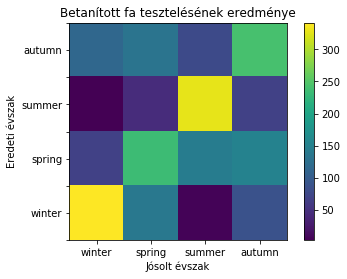

In [13]:
def plotResultArray(array):
    fig, ax = plt.subplots()
    im = ax.imshow(array)
    fig.colorbar(im)
    ax.set_xticklabels(['', 'winter', 'spring', 'summer', 'autumn'])
    ax.set_yticklabels(['', 'autumn', '', 'summer', '', 'spring', '', 'winter'])
    ax.set_xlabel('Jósolt évszak')
    ax.set_ylabel('Eredeti évszak')
    plt.title('Betanított fa tesztelésének eredménye')
    plt.show()
    
plotResultArray(treeResultArray)

## Gradient Boosting Klasszifikáció

#### Modell építése
Ugyanazon a tanító és teszthalmazon, mint a döntési fánál

In [14]:
gbc = GradientBoostingClassifier(max_features=0.4, max_depth=10)
gbc.fit(training_samples, training_features)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=0.4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

#### Pontosság összesítve

In [15]:
gbc.score(testing_samples, testing_features)

0.64337899543379

#### Eredmények kiértékelése

In [16]:
boostResultArray = calcResultArray(gbc.predict(testing_samples))
boostResultArray

[[61, 89, 57, 292], [1, 28, 403, 68], [53, 301, 98, 123], [413, 134, 0, 69]]

#### Eredmény szemléltetése hődiagrammon

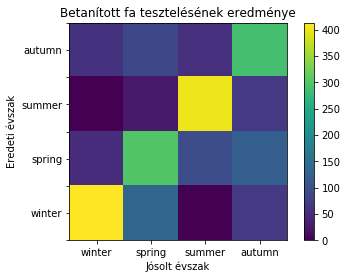

In [17]:
plotResultArray(boostResultArray)